In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from xhistogram.xarray import histogram
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.path as mpath

In [3]:
# Parameters
# ----------
Nh = 50
Nz = 100

dt = 180 # minutes
outputdt = 5 # days
runtime = 1*365 # days

locinit = "RossShelf" # Drake, Drake-upstream, Ross, coral, coral-approx, RossShelf.?
timedir = "back" # forw, back
multitimes = False # initialize at multiple different times
Nt = 12 # Number of initialized times
Dt = 6 # 5-day multiples; spacing between initialization time

# For locinit==shelf, locations are derived in calc_init_shelf.ipynb and loaded from there

# Returns
# -------
fileout = ("output"
           +".locinit_"+locinit
           +".Nh_"+str(Nh)
           +".Nz_"+str(Nz)
           +".timedir_"+timedir
           +".ntime_"+str(runtime)
           +".dt_"+str(dt))
if multitimes:
    fileout+=".itimes_N"+str(Nt)+"_D"+str(Dt)
fileout+=".nc"

ds = xr.open_dataset(fileout)

In [4]:
# Wrapper for southern ocean map
def plt_SO(max_lat=-45, central_longitude=-100):
    """Configure polar stereographic projection for Southern Ocean.
    In particular, sets extent of axis and cuts a circular boundary.
    Returns figure and axis handles into which you can plot.
    
    Parameters
    ----------
    max_lat : float, int
        Northernmost latitude in degN
    central_longitude : float, int
        Longitude to place at top of figure
    
    Returns
    -------
    fig : mpl figure handle
    ax : mpl axis handle
    """
    fig,ax = plt.subplots(figsize=(20,10),
                      subplot_kw={'projection':
                                      ccrs.SouthPolarStereo(
                                      central_longitude=-100)})
    ax.set_extent([-180, 180, -90, max_lat], ccrs.PlateCarree())
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    # Add some details
    ax.add_feature(cfeature.LAND, zorder=10,facecolor='lightgray')
    ax.gridlines()
    
    return fig,ax

### Pathway count

In [5]:
res = 2
lonG = np.arange(0,360,res)
latG = np.arange(-75,-45,res)

In [6]:
hs = histogram(ds['lon'],ds['lat'],bins=[lonG,latG],block_size=1)
hs = hs.where((hs!=0))#&(hs<1e5))

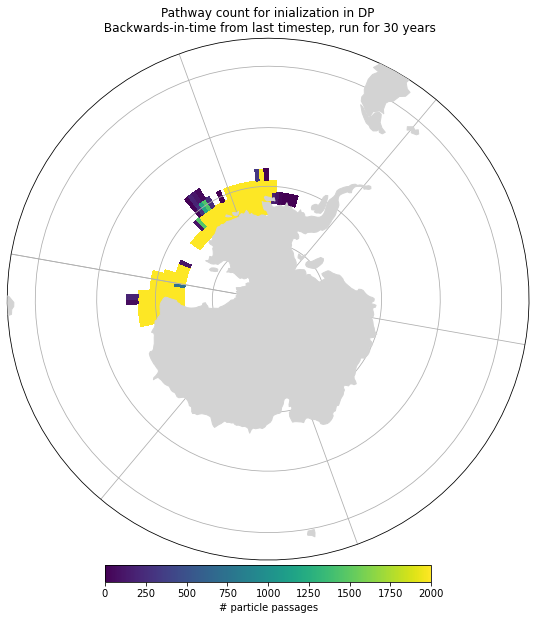

In [7]:
fig,ax = plt_SO()
im=ax.pcolormesh(hs['lon_bin'],hs['lat_bin'],hs.transpose(),
              transform=ccrs.PlateCarree())
im.set_clim([0,2000])
plt.colorbar(im,ax=ax,
             orientation='horizontal',
            fraction=0.03,pad=0.01,
            label='# particle passages')
ax.set_title(
    'Pathway count for inialization in DP\n Backwards-in-time from last timestep, run for 30 years');

### Depth distribution

In [8]:
hs_depth = histogram(ds['lon'],ds['lat'],bins=[lonG,latG],weights=ds['z'],block_size=1)
depth = hs_depth/hs

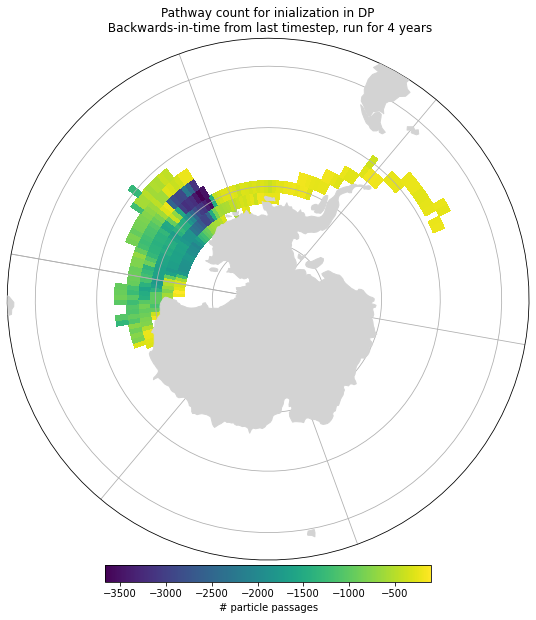

In [15]:
fig,ax = plt.subplots(figsize=(20,10),
                      subplot_kw={'projection':
                                      ccrs.SouthPolarStereo(
                                      central_longitude=-100)})

ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

im=ax.pcolormesh(depth['lon_bin'],depth['lat_bin'],depth.transpose(),
              transform=ccrs.PlateCarree())
plt.colorbar(im,ax=ax,
             orientation='horizontal',
            fraction=0.03,pad=0.01,
            label='# particle passages')

ax.add_feature(cfeature.LAND, zorder=10,facecolor='lightgray')
ax.gridlines()
ax.set_title(
    'Pathway count for inialization in DP\n Backwards-in-time from last timestep, run for 4 years');